In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import IPython
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (24,24) #in inches
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.rcParams['legend.fontsize']=13
plt.rcParams['lines.linewidth']=2

In [20]:
data = pd.read_excel('4304376.f1.xls', index_col = 0)

In [21]:
data.shape

(10508, 20)

In [22]:
data.isnull().mean().sort_values(ascending=False)

Weight        0.004758
Height        0.004663
LDL           0.001047
AST           0.000666
Uric          0.000571
ALT           0.000571
ALP           0.000571
GGT           0.000571
TB            0.000571
DB            0.000571
TC            0.000571
TG            0.000571
HDL           0.000571
Bun           0.000571
Cr            0.000571
Glu           0.000571
IB            0.000571
Gender        0.000000
Ultrasound    0.000000
Age           0.000000
dtype: float64

### Explore the dataset
1. There are null values. <br /> 
   --Need to fill null value with median value using Imputer.
2. Gender is a categorial feature.  <br /> 
   --Need to do transformation using OneHotEncoder.
3. Features are not on the same scale. <br />
   --Need to be normalized using StandardScaler.
4. The target (Ultrasound) is binary: 0/1.
5. There dataset is slightly imbalanced. <br /> 

4. It may be better to divide Ages into groups.

#### Examintion of  the target column revealed that the dataset is imbalanced.
1. Use oversampling to make it balanced

In [6]:
data.Ultrasound.value_counts()

0    7986
1    2522
Name: Ultrasound, dtype: int64

In [7]:
ratio = data.Ultrasound.value_counts()

In [8]:
print("Percentage of class 0 :", round(ratio[0]/(ratio[0]+ratio[1]), 2))
print("Percentage of class 1 :", round(ratio[1]/(ratio[0]+ratio[1]), 2))

Percentage of class 0 : 0.76
Percentage of class 1 : 0.24


### do oversampling

In [29]:
columns = data.columns.to_list()

for column in columns:
    average = data[column].mean()
    data[column] = data[column].fillna(average)

In [50]:
X = data.drop(columns="Ultrasound", axis=1)
y = data.Ultrasound

In [32]:
y.value_counts()

0    7986
1    2522
Name: Ultrasound, dtype: int64

In [52]:
# ros only receive X, y instead of a whole set, and the products are numpy arrays
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_sample(X, y)

In [41]:
len(X)

15972

## Split the whole data into train and test sets as 7 : 3

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [40]:
pd.DataFrame(y_train)[0].value_counts()

1    5590
0    5590
Name: 0, dtype: int64

### Set up numeric pipeline and categorical pipeline and combine them to a full_process_pipeline

### Define the column name of numeric attributes and categorial attributes separeately

In [42]:
""" a easy way to get column names from a dataframe  """

num_a = list(data)
num_b = data.columns.drop("Gender")

In [43]:
cat_attributes = ['Gender']

In [45]:
num_attributes = data.columns.drop(['Gender', "Ultrasound"])
num_attributes

Index(['Age', 'Height', 'Weight', 'ALT', 'AST', 'ALP', 'GGT', 'TB', 'DB', 'IB',
       'TC', 'TG', 'HDL', 'LDL', 'Bun', 'Cr', 'Glu', 'Uric'],
      dtype='object')

In [46]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [47]:
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(categories='auto'))
])

In [55]:
columns.pop()  # delete the last column name ultrasound
new_column_name = columns
X_train_df = pd.DataFrame(X_train, columns = new_column_name)
X_test_df = pd.DataFrame(X_test, columns = new_column_name)

In [64]:
# it seems that columntranformer must receive df instead of numpy array

from sklearn.compose import ColumnTransformer

process_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', cat_pipeline, cat_attributes) 
])


X_train_prepared = process_pipeline.fit_transform(X_train_df)
X_test_prepared = process_pipeline.transform(X_test_df)

### Try the model of KNN

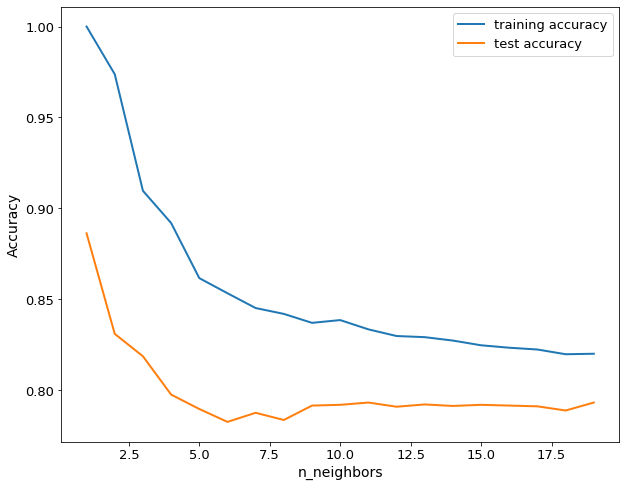

In [66]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
n_neighbors_range = range(1, 20)

for i in n_neighbors_range:
    # build the model
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_prepared, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train_prepared, y_train))
    # record generalization accuracy
    test_accuracy.append(knn.score(X_test_prepared, y_test))
plt.figure(figsize = (10, 8))    
plt.plot(n_neighbors_range, training_accuracy, label="training accuracy")
plt.plot(n_neighbors_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [67]:
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train_prepared, y_train)
print("Training accuracy is: ", knn.score(X_train_prepared, y_train))
print("Testing accuracy is: ", knn.score(X_test_prepared, y_test))

Training accuracy is:  0.8334525939177102
Testing accuracy is:  0.7931969949916527


### Try Naive Bayeses model

In [68]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_prepared, y_train)
print("Training accuracy is: ", nb.score(X_train_prepared, y_train))
print("Testing accuracy is: ", nb.score(X_test_prepared, y_test))

Training accuracy is:  0.7438282647584973
Testing accuracy is:  0.7316360601001669


### Try logistic regression model

In [70]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=100, penalty="l1")
logreg.fit(X_train_prepared, y_train)
print("Training accuracy is: ", logreg.score(X_train_prepared, y_train))
print("Testing accuracy is: ", logreg.score(X_test_prepared, y_test))

Training accuracy is:  0.8071556350626118
Testing accuracy is:  0.7954924874791319


/Users/pengl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Try SVM

In [71]:
# C=1 IS BEETER THAN C=10
from sklearn.svm import SVC
svm = SVC(kernel = "rbf", C=1, gamma=0.1)
svm.fit(X_train_prepared, y_train)
print("Training accuracy is: ", svm.score(X_train_prepared, y_train))
print("Testing accuracy is: ", svm.score(X_test_prepared, y_test))

Training accuracy is:  0.881484794275492
Testing accuracy is:  0.8290901502504173


In [72]:
# C=1 IS BEETER THAN C=10
from sklearn.svm import LinearSVC
linear_svm = LinearSVC()
linear_svm.fit(X_train_prepared, y_train)
print("Training accuracy is: ", linear_svm.score(X_train_prepared, y_train))
print("Testing accuracy is: ", linear_svm.score(X_test_prepared, y_test))

Training accuracy is:  0.8065295169946333
Testing accuracy is:  0.7942404006677797


/Users/pengl/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


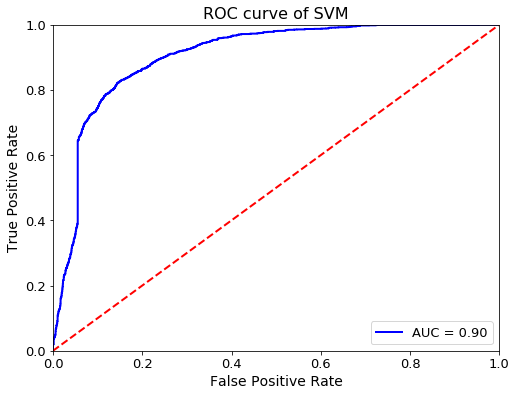

In [74]:
"""
There is difference between svm and other models on retrieving it predict_proba. It use
decison_function instead of predict_proba; also the return is a single column
instead of two columns, the value is also not between 0 and 1

The following are the codes to get predic_proba
probs = model.predict_proba(X_test_prepared)
preds = probs[:,1]


"decision function returns pairwise scores between classes" is incorrect. It should be the "score for each class" 
as it's written in the documentation page for decision_function part: "Distance of the samples X to the separating hyperplane."

"""

from sklearn import metrics
preds = svm.decision_function(X_test_prepared) # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.title('ROC curve of SVM')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Try Decision Tree model

### Add the visualization of decision tree and feature_importances

In [69]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state = 46, max_depth = 5)
tree.fit(X_train_prepared, y_train)
print("Training accuracy is: ", tree.score(X_train_prepared, y_train))
print("Testing accuracy is: ", tree.score(X_test_prepared, y_test))

Training accuracy is:  0.7929338103756708
Testing accuracy is:  0.7717028380634391


In [135]:
num_attributes_combine2 = list(num_attributes)+ ["Gender1", 'Gender0']

In [317]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="NALD_tree.dot", feature_names = num_attributes_combine2,
class_names = ['Yes', "No"], impurity=False, filled=True)

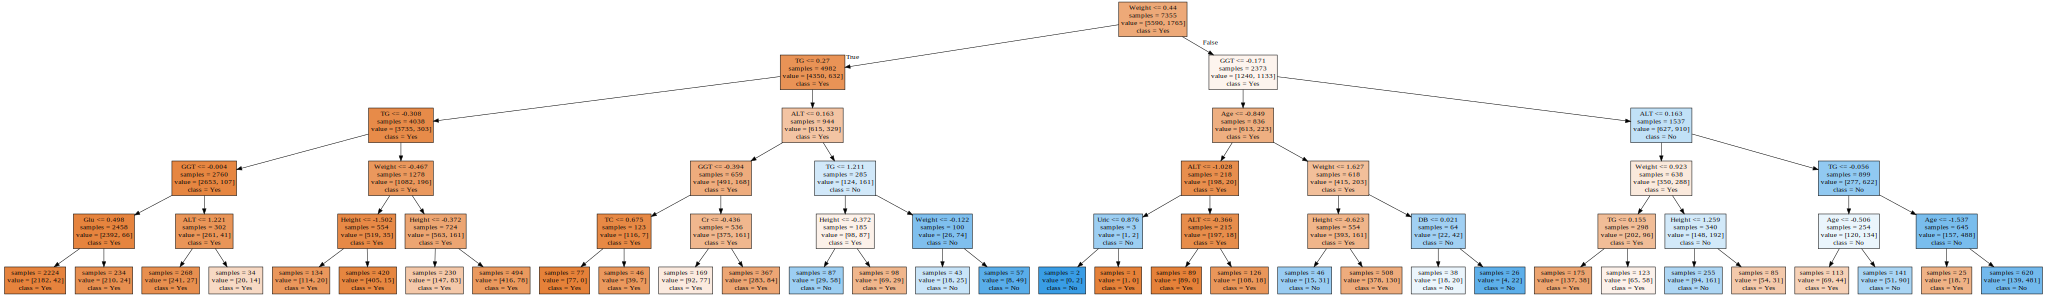

In [318]:
import graphviz

with open("NALD_tree.dot") as f: 
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### Try the random Forest model

In [75]:
from sklearn.ensemble.forest import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, random_state = 46)
forest.fit(X_train_prepared, y_train)
print("Training accuracy is: ", forest.score(X_train_prepared, y_train))
print("Testing accuracy is: ", forest.score(X_test_prepared, y_test))

Training accuracy is:  1.0
Testing accuracy is:  0.9167362270450752


In [76]:
len(tree.feature_importances_)

20

In [90]:
num_attributes_combine2 = list(num_attributes)+ ["Gender1", 'Gender0']
important_features = []
for label, feature in zip(num_attributes_combine2, tree.feature_importances_):  ## wrong
    important_features.append({label: feature})

Age :  0.042352046796713706
Height :  0.021230128251939883
Weight :  0.5199961364777095
ALT :  0.07600471214373224
AST :  0.002557974750248966
ALP :  0.0
GGT :  0.04237294427279993
TB :  0.0
DB :  0.0
IB :  0.0
TC :  0.0060760923622961
TG :  0.2446905518919494
HDL :  0.005697847214068484
LDL :  0.0
Bun :  0.0
Cr :  0.015809579167823436
Glu :  0.016807973311897356
Uric :  0.006404013358820954
Gender1 :  0.0
Gender0 :  0.0


In [82]:
important_features

[{'Age': 0.042352046796713706},
 {'Height': 0.021230128251939883},
 {'Weight': 0.5199961364777095},
 {'ALT': 0.07600471214373224},
 {'AST': 0.002557974750248966},
 {'ALP': 0.0},
 {'GGT': 0.04237294427279993},
 {'TB': 0.0},
 {'DB': 0.0},
 {'IB': 0.0},
 {'TC': 0.0060760923622961},
 {'TG': 0.2446905518919494},
 {'HDL': 0.005697847214068484},
 {'LDL': 0.0},
 {'Bun': 0.0},
 {'Cr': 0.015809579167823436},
 {'Glu': 0.016807973311897356},
 {'Uric': 0.006404013358820954},
 {'Gender1': 0.0},
 {'Gender0': 0.0}]

### Draw a feature importance graph

### Try gradient boosting calssifier

In [98]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state = 0, max_depth =1)
gbrt.fit(X_train_prepared, y_train)
print("Training accuracy is: ", gbrt.score(X_train_prepared, y_train))
print("Testing accuracy is: ", gbrt.score(X_test_prepared, y_test))

Training accuracy is:  0.8083184257602862
Testing accuracy is:  0.7923622704507512


In [148]:
gbrt = GradientBoostingClassifier(random_state = 0, max_depth =1)
gbrt.fit(X_train_prepared, y_train)
print("Training accuracy is: ", gbrt.score(X_train_prepared, y_train))
print("Testing accuracy is: ", gbrt.score(X_test_prepared, y_test))

Training accuracy is:  0.8327635717215917
Testing accuracy is:  0.8248803827751197


## calculate auc and f1

In [99]:
from sklearn.metrics import f1_score
models = [knn, logreg, nb, svm, tree, forest, gbrt]
model_names = ["knn", "logreg", "nb", "svm", "tree","forest", "gbrt"]
for i in range(len(models)):
    y_pred = models[i].predict(X_test_prepared)
    f1 =f1_score(y_test, y_pred, average='binary')
    print(model_names[i], "F1 score: ", f1)

knn F1 score:  0.8034120214243204
logreg F1 score:  0.7978547854785478
nb F1 score:  0.7025901942645698
svm F1 score:  0.8361672334466893
tree F1 score:  0.7803212851405622
forest F1 score:  0.920533758215495
gbrt F1 score:  0.7985422150232842


In [100]:
from sklearn import metrics

models2 = [knn, logreg, nb, tree, forest, gbrt]
model_names2 = ["knn", "logreg", "nb", "tree","forest", "gbrt"]
for i in range(len(models2)):
    preds_p = models2[i].predict_proba(X_test_prepared)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds_p)
    roc_auc = metrics.auc(fpr, tpr)
    print(model_names2[i], "Auc: ", roc_auc)

knn Auc:  0.8695936257145326
logreg Auc:  0.8790337471188765
nb Auc:  0.8073984604279252
tree Auc:  0.8441449786929245
forest Auc:  0.9823004255840982
gbrt Auc:  0.8750267383591461


### Try gridSearchCV to fine tune parameters

### To prevent information leaking, add the whole pipe into gridSearchCV()

In [120]:
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
    ('process', process_pipeline),
    ('model', LogisticRegression()),
])
para_grid = [{'model__C': [0.1, 1, 10, 100]}]
grid_search = GridSearchCV(pipe, para_grid, cv=10, n_jobs=4)
grid_search.fit(X_train_df, y_train)

/Users/pengl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                            

In [108]:
print("Best accuracy is: ", grid_search.best_score_)
print("Best parameter is: ", grid_search.best_params_)

Best accuracy is:  0.8073345259391771
Best parameter is:  {'model__C': 10}


In [121]:
"""

Must pay attention for GridSearchCV
1. fit(X,y)    X should be df
2. param_grid must indicate which estimator does the parameter belongs. e.g., it belongst to model or process 
    use double -- connect estimator and parameters   'model _ _ C'

"""

from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('process', process_pipeline),
    ('model', RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True)),
])

para_grid = [{ 
    'model__n_estimators': [200, 700],
    'model__max_features': ['auto', 'sqrt', 'log2']
}]

grid_search = GridSearchCV(pipe, para_grid, cv=5, n_jobs=4)
grid_search.fit(X_train_df, y_train)

print("Best accuracy is: ", grid_search.best_score_)
print("Best parameter is: ", grid_search.best_params_)

/Users/pengl/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best accuracy is:  0.9084973166368515
Best parameter is:  {'model__max_features': 'log2', 'model__n_estimators': 700}
